In [117]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [118]:
# load dataset
data = pd.read_csv('tabular_data/plant_growth_data.csv')
print(data.head())

  Soil_Type  Sunlight_Hours Water_Frequency Fertilizer_Type  Temperature  \
0      loam        5.192294       bi-weekly        chemical    31.719602   
1     sandy        4.033133          weekly         organic    28.919484   
2      loam        8.892769       bi-weekly            none    23.179059   
3      loam        8.241144       bi-weekly            none    18.465886   
4     sandy        8.374043       bi-weekly         organic    18.128741   

    Humidity  Growth_Milestone  
0  61.591861                 0  
1  52.422276                 1  
2  44.660539                 0  
3  46.433227                 0  
4  63.625923                 0  


In [119]:
print(data.columns.tolist())

['Soil_Type', 'Sunlight_Hours', 'Water_Frequency', 'Fertilizer_Type', 'Temperature', 'Humidity', 'Growth_Milestone']


In [120]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Soil_Type         193 non-null    object 
 1   Sunlight_Hours    193 non-null    float64
 2   Water_Frequency   193 non-null    object 
 3   Fertilizer_Type   193 non-null    object 
 4   Temperature       193 non-null    float64
 5   Humidity          193 non-null    float64
 6   Growth_Milestone  193 non-null    int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 10.7+ KB
None


In [121]:
print(data.describe())

       Sunlight_Hours  Temperature    Humidity  Growth_Milestone
count      193.000000   193.000000  193.000000        193.000000
mean         6.826484    25.076087   58.098927          0.497409
std          1.599509     5.354170   12.631799          0.501294
min          4.033133    15.200000   30.567682          0.000000
25%          5.477000    20.637095   49.300000          0.000000
50%          6.833290    25.912336   59.182806          0.000000
75%          8.241144    29.757938   69.100000          1.000000
max          9.913903    34.810103   79.648240          1.000000


In [122]:
data_encoded = pd.get_dummies(data, columns = ['Soil_Type', 'Water_Frequency', 'Fertilizer_Type'], drop_first=True)
print(data_encoded.head())

   Sunlight_Hours  Temperature   Humidity  Growth_Milestone  Soil_Type_loam  \
0        5.192294    31.719602  61.591861                 0            True   
1        4.033133    28.919484  52.422276                 1           False   
2        8.892769    23.179059  44.660539                 0            True   
3        8.241144    18.465886  46.433227                 0            True   
4        8.374043    18.128741  63.625923                 0           False   

   Soil_Type_sandy  Water_Frequency_daily  Water_Frequency_weekly  \
0            False                  False                   False   
1             True                  False                    True   
2            False                  False                   False   
3            False                  False                   False   
4             True                  False                   False   

   Fertilizer_Type_none  Fertilizer_Type_organic  
0                 False                    False  
1       

Text(0.5, 1.0, 'Correlation Heatmap')

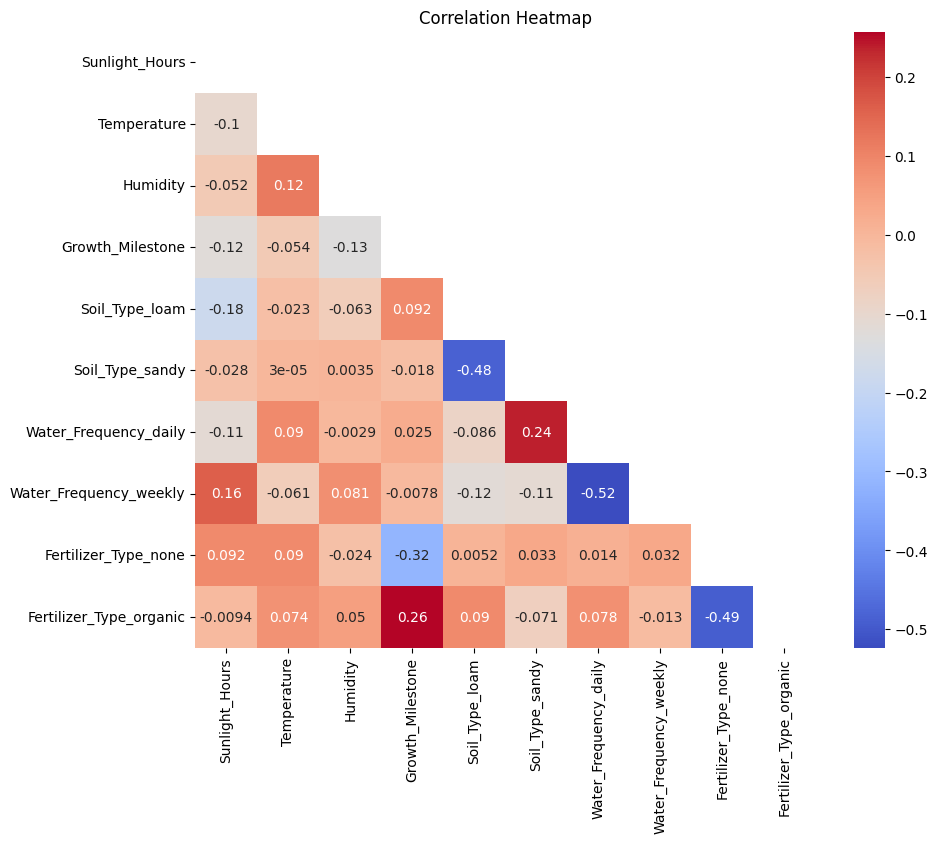

In [123]:
# heatmap to see correlations
plt.figure(figsize=(10, 8))
corr = data_encoded.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

Fertilizer plays the most critical role in plant growth.

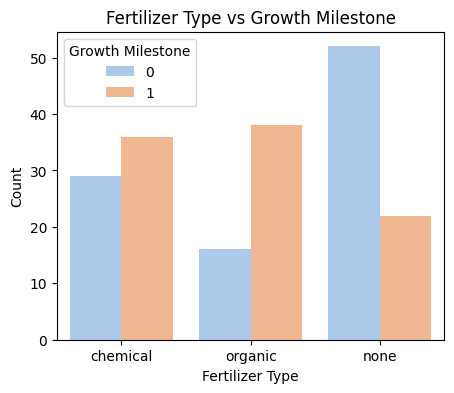

In [124]:
plt.figure(figsize=(5, 4))
sns.countplot(x='Fertilizer_Type', hue='Growth_Milestone', data=data, palette='pastel')
plt.title('Fertilizer Type vs Growth Milestone')
plt.xlabel('Fertilizer Type')   
plt.ylabel('Count')
plt.legend(title='Growth Milestone')
plt.show()

In [125]:
print(corr['Growth_Milestone'].sort_values(ascending=False))

Growth_Milestone           1.000000
Fertilizer_Type_organic    0.257165
Soil_Type_loam             0.092334
Water_Frequency_daily      0.025399
Water_Frequency_weekly    -0.007809
Soil_Type_sandy           -0.018362
Temperature               -0.053577
Sunlight_Hours            -0.122212
Humidity                  -0.130328
Fertilizer_Type_none      -0.315610
Name: Growth_Milestone, dtype: float64


In [126]:
# train-test split
data_encoded = pd.get_dummies(data, columns = ['Soil_Type', 'Water_Frequency', 'Fertilizer_Type'], drop_first=True)

X = data_encoded.drop('Growth_Milestone', axis=1)
y = data_encoded['Growth_Milestone']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"train dataset: {X_train.shape[0]}")
print(f"test dataset: {X_test.shape[0]}")


train dataset: 135
test dataset: 58


In [127]:
# data augmentation 
def augment_training_data(X_data, y_data, samples_per_row=5):
    train_data = pd.concat([X_data, y_data], axis=1)
    
    new_data = []
    numeric_cols = ['Sunlight_Hours', 'Temperature', 'Humidity']
    
    for index, row in train_data.iterrows():
        for _ in range(samples_per_row):
            new_row = row.copy()
            
            for col in numeric_cols:
                noise = np.random.normal(0, 0.5)
                new_row[col] += noise
            
            new_data.append(new_row)
    
    new_df = pd.DataFrame(new_data)
    
    augmented_train = pd.concat([train_data, new_df], ignore_index=True)
    
    return augmented_train.drop('Growth_Milestone', axis=1), augmented_train['Growth_Milestone']


X_train_aug, y_train_aug = augment_training_data(X_train, y_train, samples_per_row=10)

print(f"New training data size: {X_train_aug.shape[0]}")

New training data size: 1485


In [128]:
#scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_aug)
X_test_scaled = scaler.transform(X_test)

In [129]:
# hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist,
    n_iter=50,
    cv=30,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

#train model
random_search.fit(X_train_scaled, y_train_aug)

print("Best Hyperparameters:", random_search.best_params_)

Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}


In [130]:
# test model
best_rf = random_search.best_estimator_
cv_scores = cross_val_score(best_rf, X_train_scaled, y_train_aug, cv=75, scoring='accuracy')

y_pred = best_rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Accuracy:", accuracy_score(y_test, y_pred))

# save model
joblib.dump(best_rf, 'plant_growth.pkl')

              precision    recall  f1-score   support

           0       0.67      0.48      0.56        29
           1       0.59      0.76      0.67        29

    accuracy                           0.62        58
   macro avg       0.63      0.62      0.61        58
weighted avg       0.63      0.62      0.61        58

Confusion Matrix:
 [[14 15]
 [ 7 22]]

 Accuracy: 0.6206896551724138


['plant_growth.pkl']